In [13]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Preprocessing

In [20]:
# NPZ 파일 로드
train_data = np.load('train_dataset.npz')
X_audio_train = train_data["X_audio"]
y_train = train_data["y"]
X_text_train = train_data["X_input_ids"]  # 텍스트 token ids 활용
# (주의: attention mask는 사용할 경우 별도 branch나 마스킹 기법을 추가할 수 있습니다.)

In [18]:
valid_data = np.load('valid_dataset.npz')
X_audio_valid = valid_data["X_audio"]
y_valid = valid_data["y"]
X_text_valid = valid_data["X_input_ids"]

In [19]:
test_data = np.load('test_dataset.npz')
X_audio_test = test_data["X_audio"]
y_test = test_data["y"]
X_text_test = test_data["X_input_ids"]

In [21]:
# 현재 X_audio는 (batch, 1, n_mfcc, time_frames). transpose하여 (batch, n_mfcc, time_frames, 1)
X_audio_train = np.transpose(X_audio_train, (0, 2, 3, 1))
X_audio_valid = np.transpose(X_audio_valid, (0, 2, 3, 1))
X_audio_test  = np.transpose(X_audio_test, (0, 2, 3, 1))

print("After transpose:")
print("X_audio_train shape:", X_audio_train.shape)
print("X_text_train shape:", X_text_train.shape)
print("y_train shape:", y_train.shape)

After transpose:
X_audio_train shape: (10896, 20, 377, 1)
X_text_train shape: (10896, 32)
y_train shape: (10896, 4)


In [28]:
import os
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, Add, Activation,
                                     Embedding, GlobalAveragePooling1D, Concatenate)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer

# 토크나이저 초기화
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# --- Residual Block 정의 ---
def res_block(input_tensor, filters, kernel_size=(3,3), strides=(1,1), weight_decay=0.1):
    """
    기본 Residual Block: 두 개의 Conv2D 레이어와 skip connection.
    """
    x = Conv2D(filters, kernel_size, padding='same', strides=strides,
               activation='relu', kernel_regularizer=l2(weight_decay))(input_tensor)
    x = BatchNormalization()(x)
    x = Conv2D(filters, kernel_size, padding='same', strides=(1,1),
               activation=None, kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)

    shortcut = input_tensor
    if shortcut.shape[-1] != filters or strides != (1,1):
        shortcut = Conv2D(filters, (1,1), strides=strides, padding='same',
                          kernel_regularizer=l2(weight_decay))(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# --- Audio Branch (CNN + 3 Residual Blocks) ---
# X_audio_train는 미리 NPZ 등에서 로드하여 전처리한 결과로, shape: (batch, n_mfcc, time_frames, 1)로 가정
audio_input = Input(shape=(X_audio_train.shape[1], X_audio_train.shape[2], X_audio_train.shape[3]), name="audio_input")

# 초기 컨볼루션 및 첫 번째 블록 (64 필터)
a = Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.1))(audio_input)
a = BatchNormalization()(a)
a = MaxPooling2D((2,2))(a)

a = res_block(a, 64, strides=(1,1), weight_decay=0.1)
a = MaxPooling2D((2,2))(a)

# 두 번째 residual block (128 필터)
a = res_block(a, 128, strides=(1,1), weight_decay=0.1)
a = MaxPooling2D((2,2))(a)

# 세 번째 residual block (256 필터)
a = res_block(a, 256, strides=(1,1), weight_decay=0.1)
a = MaxPooling2D((2,2))(a)

a = Flatten()(a)
a = Dense(256, activation='relu', kernel_regularizer=l2(0.1))(a)
a = Dropout(0.4)(a)
# audio branch 최종 벡터 (dimension: 256)

# --- Text Branch (Embedding + GlobalAveragePooling) ---
# X_text_train는 NPZ 등으로 로드한 결과 (batch, max_length)로 가정, 예: max_length = 32
max_length = X_text_train.shape[1]  # 예: 32
text_input = Input(shape=(max_length,), name="text_input")

vocab_size = tokenizer.vocab_size  # BERT vocab_size, 보통 30522
embedding_dim = 128

t = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length)(text_input)
t = GlobalAveragePooling1D()(t)
t = Dense(128, activation='relu')(t)
# text branch 최종 벡터 (dimension: 128)

# --- Fusion: Concatenate Audio and Text Branch ---
combined = Concatenate()([a, t])  # 최종 dimension = 256 + 128 = 384

# Fully Connected Layers (MLP)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.1))(combined)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.1))(x)
x = Dropout(0.4)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.1))(x)
x = Dropout(0.4)(x)

# 출력 레이어: y_train는 one-hot 인코딩, num_classes에 맞춤
num_classes = y_train.shape[1]
output = Dense(num_classes, activation='softmax')(x)

# 모델 생성 및 컴파일
model = Model(inputs=[audio_input, text_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ audio_input         │ (None, 20, 377,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 20, 377,   │        320 │ audio_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 377,   │        128 │ conv2d_48[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 10, 188,   │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 10, 188,   │     18,496 │ max_pooling2d_20… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 188,   │        256 │ conv2d_49[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 10, 188,   │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 10, 188,   │      2,112 │ max_pooling2d_20… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 188,   │        256 │ conv2d_50[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 188,   │        256 │ conv2d_51[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 10, 188,   │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_14       │ (None, 10, 188,   │          0 │ add_14[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 5, 94, 64) │          0 │ activation_14[0]… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 5, 94,     │     73,856 │ max_pooling2d_21… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 94,     │        512 │ conv2d_52[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 5, 94,     │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 5, 94,     │      8,320 │ max_pooling2d_21

 Total params: 6,782,276 (25.87 MB)

 Trainable params: 6,779,524 (25.86 MB)

 Non-trainable params: 2,752 (10.75 KB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 학습 시 ReduceLROnPlateau 콜백 설정
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# 멀티모달 모델 학습
history = model.fit(
    x=[X_audio_train, X_text_train],  # 두 가지 입력: 오디오와 텍스트 토큰
    y=y_train,
    validation_data=([X_audio_valid, X_text_valid], y_valid),
    epochs=100,
    batch_size=32,
    callbacks=[lr_scheduler]
)

Epoch 1/100
341/341 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.3354 - loss: 10.4950 - val_accuracy: 0.3745 - val_loss: 6.0339 - learning_rate: 1.0000e-04
Epoch 2/100
341/341 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.3651 - loss: 5.1554 - val_accuracy: 0.2495 - val_loss: 4.1318 - learning_rate: 1.0000e-04
Epoch 3/100
341/341 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.3796 - loss: 3.0361 - val_accuracy: 0.4125 - val_loss: 2.2748 - learning_rate: 1.0000e-04
Epoch 4/100
341/341 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.4160 - loss: 2.1330 - val_accuracy: 0.2500 - val_loss: 2.4181 - learning_rate: 1.0000e-04
Epoch 5/100
341/341 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.4346 - loss: 1.7272 - val_accuracy: 0.3255 - val_loss: 1.8485 - learning_rate: 1.0000e-04
Epoch 6/100
341/341 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.4391 - loss: 1.5374 - val_accuracy: 0.2760 - val_loss: 1.9973 - learning_rate: 1.0000e-04
Epoch 7/100
341/341 ━━━━━━━━━━━━━━━━━━━━ 10s 28

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4521 - loss: 1.3802
Final Accuracy on Test Set: 0.43568840622901917
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
              precision    recall  f1-score   support

   australia       0.10      0.29      0.15        90
     england       0.48      0.56      0.52       298
      indian       0.35      0.80      0.49        90
          us       0.71      0.35      0.47       626

    accuracy                           0.44      1104
   macro avg       0.41      0.50      0.41      1104
weighted avg       0.57      0.44      0.46      1104



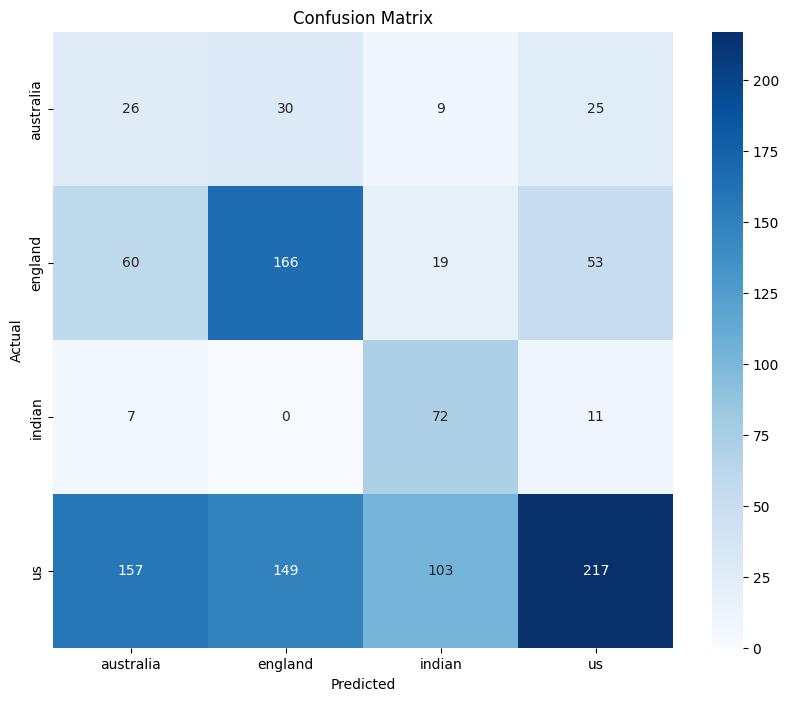

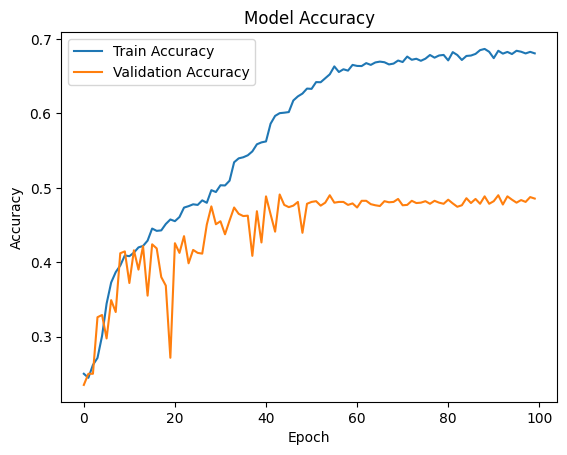

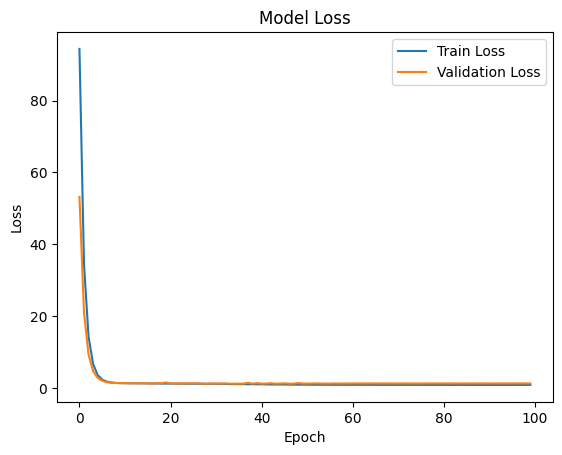

/content/multimodal_model.h5

In [24]:
# Accent label mapping (예시)
label_mapping = {0: 'australia', 1: 'england', 2: 'indian', 3: 'us'}
target_names = [label_mapping[i] for i in range(len(label_mapping))]

# --- Evaluate the Model on Test Data ---
test_loss, test_accuracy = model.evaluate([X_audio_test, X_text_test], y_test)
print("Final Accuracy on Test Set:", test_accuracy)

# --- Confusion Matrix and Classification Report ---
y_pred = model.predict([X_audio_test, X_text_test])
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print(classification_report(y_true_labels, y_pred_labels, target_names=target_names))
cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# --- Plot Training History ---
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend()
plt.show()

# --- Save the Model ---
model.save("multimodal_model.h5")

# For environments that support file links (like Jupyter Notebook)
from IPython.display import FileLink
FileLink("multimodal_model.h5")
